# Benin Solar Dataset EDA
## Profile, clean, and explore Benin solar data for insights.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
import importlib
import eda
importlib.reload(eda)  # Reload to ensure latest module

<module 'eda' from 'c:\\Users\\Lidya\\Documents\\projects\\solar-challenge-week0\\scripts\\eda.py'>

## Loading Data

In [2]:
import pandas as pd
# Load data
file_path = '../data/benin_clean.csv'
df = eda.load_data(file_path)

# Check if data loaded successfully
if df is None or not isinstance(df, pd.DataFrame):
    print("Failed to load data. Check file path.")
else:
    print("Data loaded successfully!")
df.head()

   

Data loaded successfully!


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 05:43,0.0,0.0,0.6,1.2,1.2,25.2,92.7,1.8,2.1,0.3,225.4,4.8,977,0,0.0,25.0,24.8,NaN
1,2021-10-25 05:44,0.2,0.0,0.7,1.4,1.4,25.2,92.7,1.4,1.9,0.4,231.2,5.8,977,0,0.0,25.0,24.7,NaN
2,2021-10-25 05:45,0.5,0.0,0.8,1.6,1.6,25.2,92.8,1.5,1.9,0.4,229.9,7.9,977,0,0.0,25.0,24.7,NaN
3,2021-10-25 05:46,0.8,0.0,0.9,1.9,1.9,25.2,92.6,1.6,2.1,0.4,230.1,7.0,977,0,0.0,25.0,24.7,NaN
4,2021-10-25 05:47,1.0,0.0,1.0,2.1,2.1,25.1,92.5,1.6,1.9,0.4,230.0,7.0,977,0,0.0,25.0,24.7,NaN


## Summary Statistics & Missing Values
Stats for numeric columns, flag columns with >5% nulls.

In [3]:
# Define key columns and country name
key_columns = ['GHI', 'DNI', 'DHI', 'Tamb', 'TModA', 'TModB', 'WS', 'WSgust', 'WD', 'RH']
country_name = 'Benin'

# Summarize statistics
summary_stats = eda.summarize_statistics(df)  # Use eda.sum_stat if using original eda.py
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
                  GHI            DNI            DHI           ModA  \
count  268215.000000  268215.000000  268215.000000  268215.000000   
mean      454.081218     296.409415     228.166180     443.109538   
std       319.096010     283.534417     150.064955     318.155810   
min         0.000000       0.000000       0.000000       0.000000   
25%       156.500000       7.000000     112.400000     144.200000   
50%       430.300000     233.800000     211.400000     410.800000   
75%       743.900000     548.000000     330.300000     733.400000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  268215.000000  268215.000000  268215.000000  268215.000000   
mean      430.224900      29.868625      50.954453       2.897560   
std       308.539523       4.825459      27.871583       1.474324   
min         0.000000      14.900000       3.300000       0.000000   
25%       14

## Outlier Detection & Cleaning
Z-scores for GHI, DNI, DHI, ModA, ModB, WS, WSgust; handle negatives, missing values.

In [4]:
# Detect negative and missing values
eda.detect_outliers_and_missing(df, key_columns)

# Z-score Computing
eda.calculate_z_scores(df,key_columns)

# Cleaning
df_clean = eda.clean_data(df, key_columns, country_name)



Negative Values in Key Columns:

Columns with >5.0% Nulls: None

Outliers (|Z|>3): 1937 rows
Cleaned DataFrame Shape: (268215, 19)
Remaining Negatives in Key Columns:
GHI: 0
DNI: 0
DHI: 0
Tamb: 0
TModA: 0
TModB: 0
WS: 0
WSgust: 0
WD: 0
RH: 0
Cleaned data exported to ..\data\benin_clean.csv


## Time Series Analysis
Plot GHI, DNI, DHI, Tamb vs. Timestamp; analyze patterns.

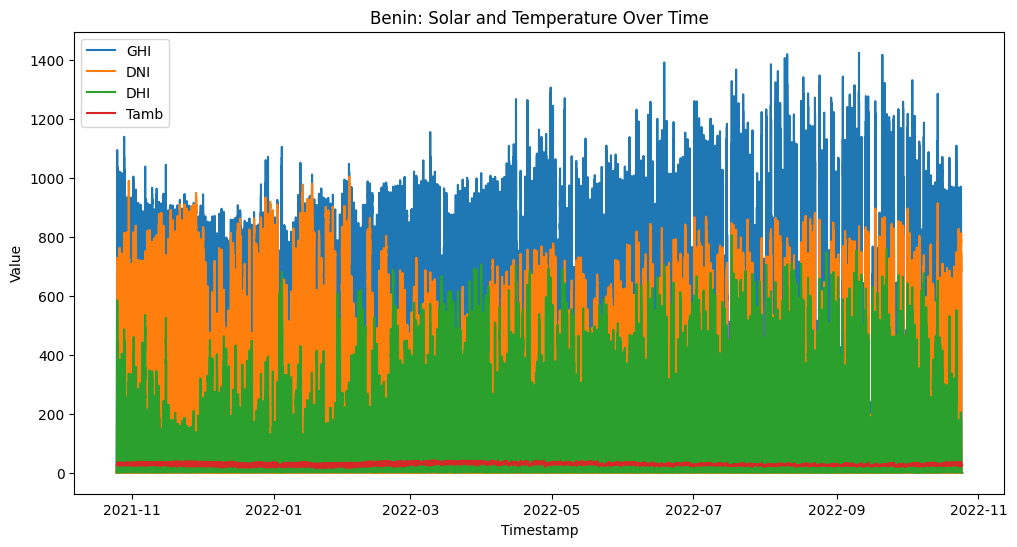

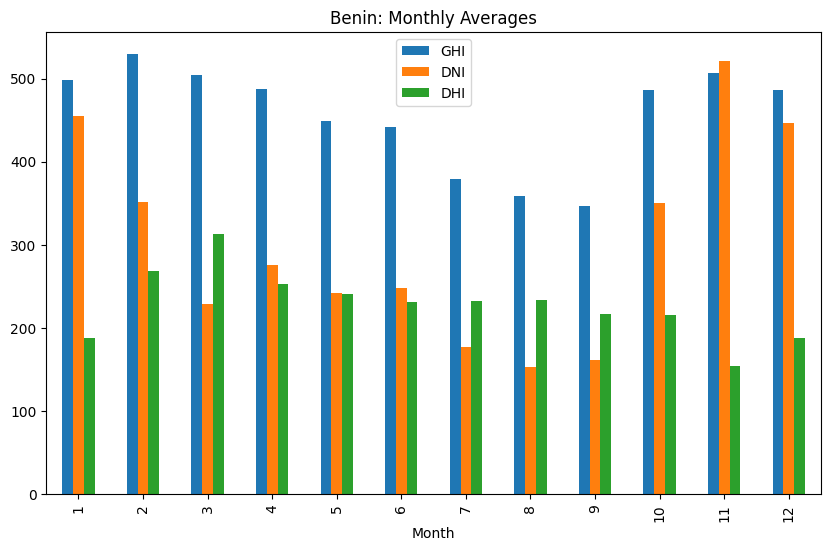

In [5]:
eda.plot_time_series(df_clean, country_name)

## Cleaning Impact
Average ModA, ModB by Cleaning flag.

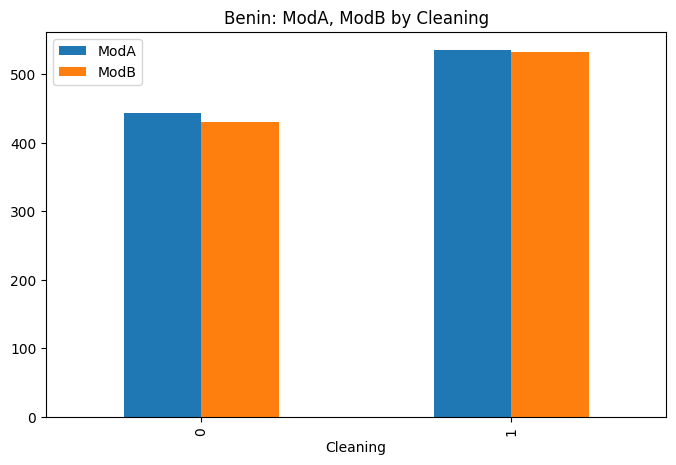

In [6]:
eda.plot_cleaning_impact(df_clean, country_name)

## Correlation Analysis
Heatmap for GHI, DNI, DHI, TModA, TModB.

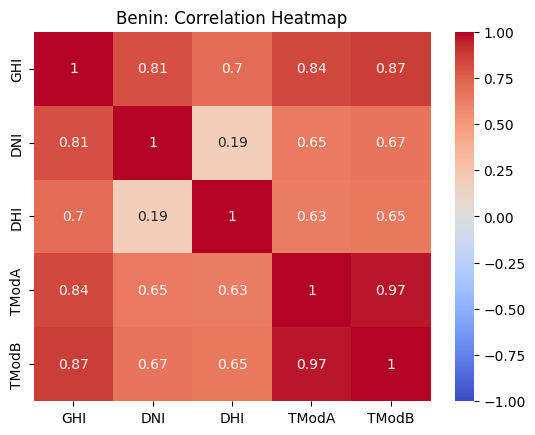

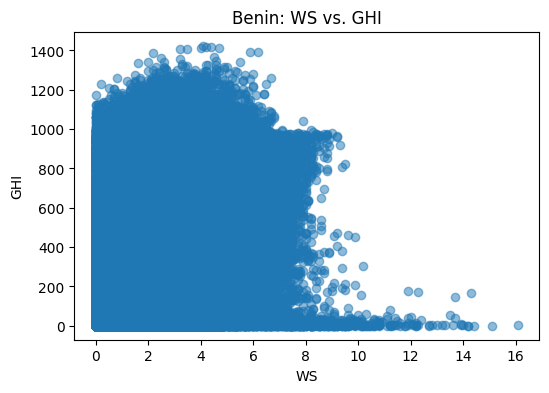

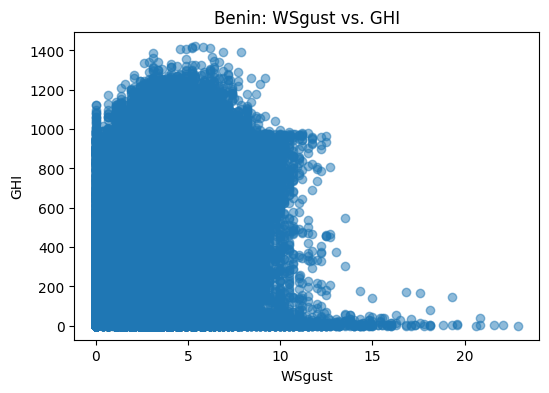

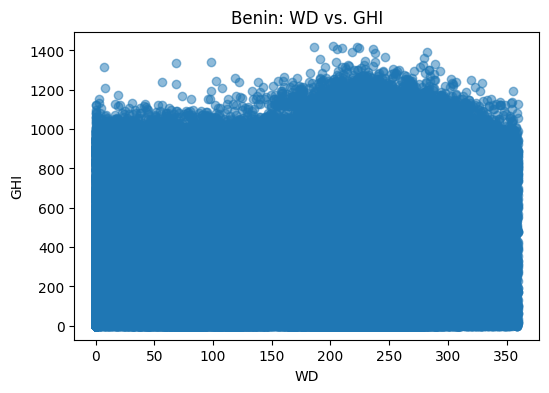

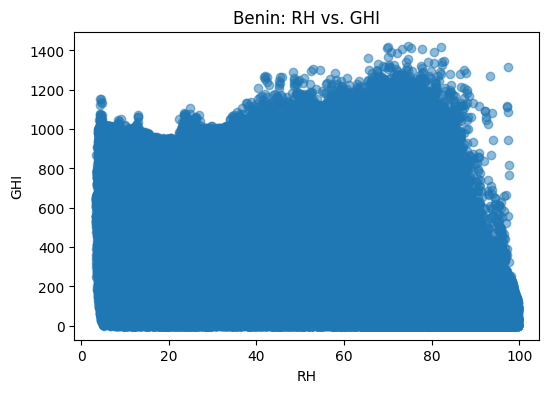

In [7]:
eda.analyze_correlations(df_clean,country_name)

## Wind & Distribution Analysis
Wind rose for WS/WD, histograms for GHI, WS.

In [8]:
# Windrose for WS/WD
eda.plot_wind_rose(df_clean,country_name)

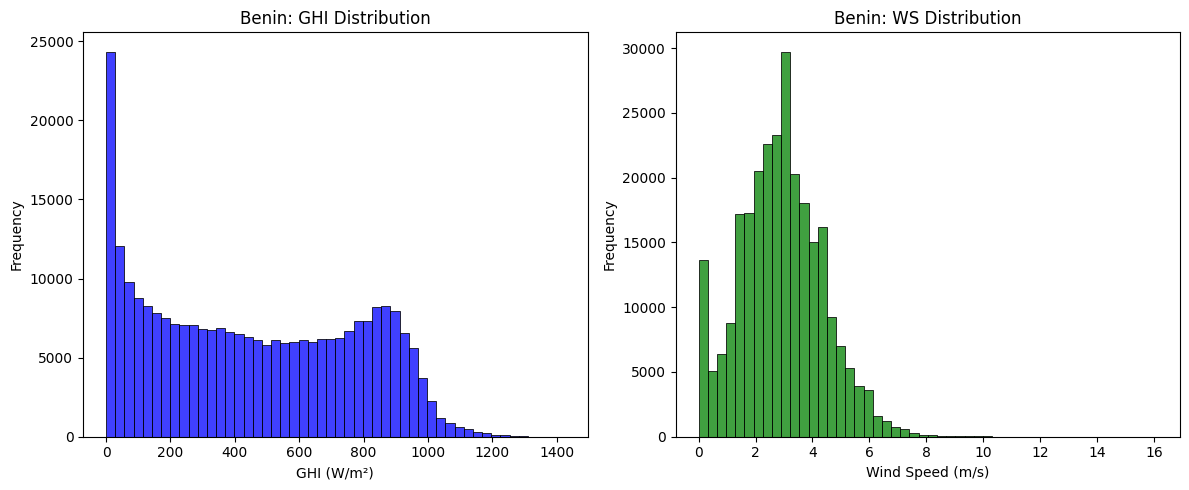

In [9]:
# Histogram for GHI and WS
eda.plot_distributions(df_clean,country_name)

## Temperature Analysis
RH influence on Tamb, GHI.

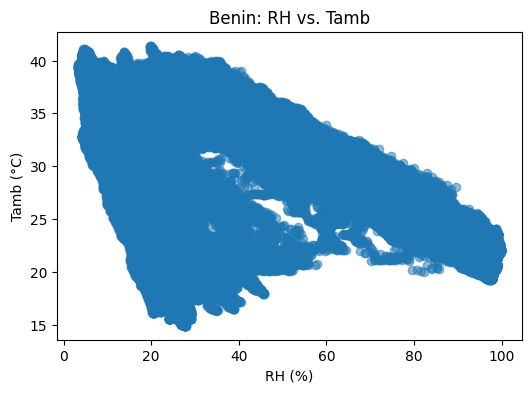

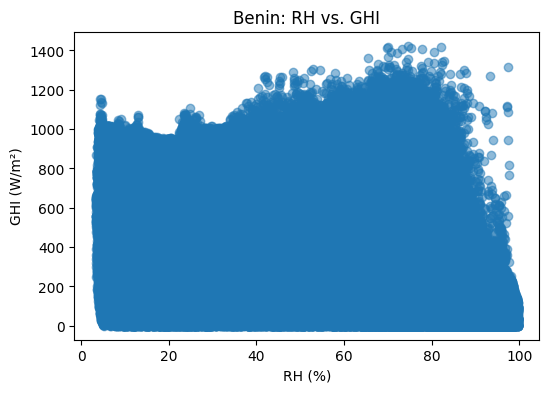

In [10]:
# Scatter plot of RH vs Tamb || RH vs GHI
eda.plot_temperature_relations(df_clean,country_name)

## Bubble Chart
GHI vs. Tamb, bubble size = RH.

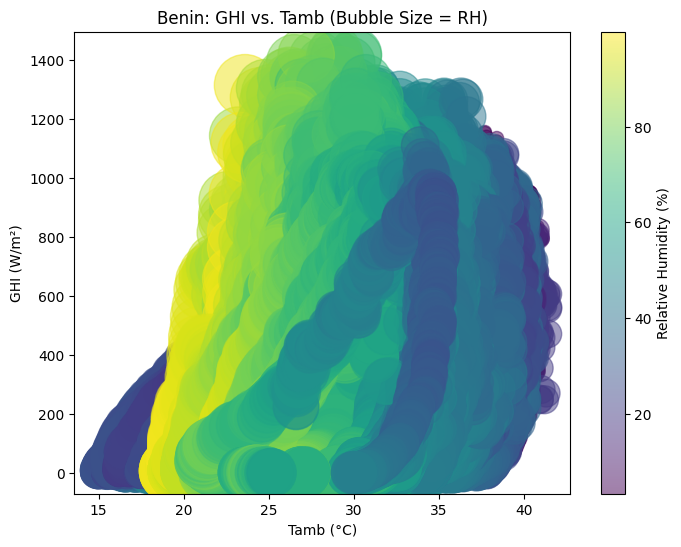

In [11]:
# Bubble chart: GHI vs. Tamb, bubble size = RH
eda.plot_bubble_chart(df_clean, country_name)